# Classification - Bank Marketing

http://archive.ics.uci.edu/ml/datasets/Bank+Marketing

Classification labels are unbalanced. Might be worth considering running through these metrics and techniques: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/. Also: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [1]:
# Import third party modules
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import shap
import pandas as pd
import numpy as np
import random

# For visualisations
shap.initjs()
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
# Remove 'Consider rewriting this model with the Functional API' warnings from Tensorflow
# These warnings can be ignored: https://github.com/tensorflow/recommenders/issues/188
tf.get_logger().setLevel('ERROR')

In [3]:
# Import custom modules
from metrics.sensitivity import calculate_sensitivity
from metrics.infidelity import calculate_infidelity

from model.metadata import get_feature_names, get_feature_names_of_type, append_indices, append_baselines
from model.feature_columns import get_normalization_parameters, create_numeric_columns, create_categorical_columns
from model.dataset_converter import convert_df_dataset, convert_dataframe_numpy, convert_numpy_tensor


Sensitivity module imported
Dataset converter module imported
Metadata module imported
Infidelity module imported
Feature columns module imported


In [4]:
# Import data from csv
csv_file = 'data/classification-bank/bank-full.csv'
dataframe = pd.read_csv(csv_file, index_col=False, sep=';')

In [5]:
# Add a random column to use to compare to more meaningful columns
dataframe['noise'] = np.random.randint(0,5, size=len(dataframe))

In [6]:
# Convert the Y value to 1 or 0
dataframe['y_binary'] = np.where(dataframe['y']=='yes', 1, 0)
dataframe.drop(['y'], axis=1, inplace=True)

In [7]:
# Convert day to strings (as this is really a categorical column):
dataframe['day'] = dataframe['day'].astype(str)

In [8]:
dataframe['day'][0]

'5'

In [9]:
# Sanity check
dataframe.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,noise,y_binary
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,2,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,4,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,2,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,4,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,1,0


In [10]:
# Import metadata
import json
file = open('metadata.json')
metadata = json.load(file)

# Check this list aligns with the dataframe headers
df_headers = [f for f in dataframe]
for index, metadata_header in enumerate(metadata, start=0):
    assert(df_headers[index] == metadata_header['name'])
print('Confirm metadata aligns with dataframe')

Confirm metadata aligns with dataframe


In [11]:
# Append indexes to metadata
metadata = append_indices(metadata)
    
# Append baselines to metadata
    # Numerical: mean
    # Ordinal: mid-point of all values
    # Nominal: mode
metadata = append_baselines(metadata, dataframe)

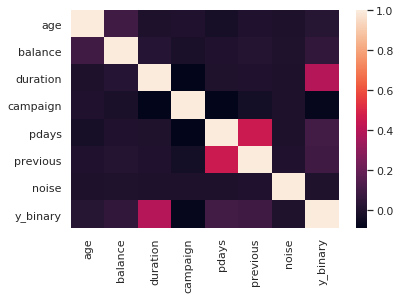

In [12]:
# Plot correlation matrix for numerical variables
# We can see [call] duration seems to have an impact on whether a loan is taken - this feels reasonable
corr = dataframe.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [13]:
# Split data (note this randomises the split so no stratification issues)
train_df, test_df = train_test_split(dataframe, test_size=0.2)
train_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,noise,y_binary
13164,28,blue-collar,single,secondary,no,517,no,yes,cellular,8,jul,681,1,-1,0,unknown,2,1
33830,55,management,married,tertiary,no,6770,no,no,cellular,27,apr,167,1,-1,0,unknown,0,0
29263,75,retired,married,primary,no,3324,no,no,cellular,2,feb,149,1,-1,0,unknown,0,0
9698,28,blue-collar,married,secondary,no,822,yes,no,unknown,6,jun,209,18,-1,0,unknown,4,0
1345,42,admin.,married,secondary,no,323,yes,yes,unknown,8,may,280,2,-1,0,unknown,3,0


In [14]:
batch_size = 100
train_ds = convert_df_dataset(train_df, 'y_binary', batch_size=batch_size)
test_ds = convert_df_dataset(test_df, 'y_binary', shuffle=False, batch_size=batch_size)

In [15]:
# Reset our feature columns
feature_columns = []

In [16]:
# Normalize and add numeric columns
# From: https://towardsdatascience.com/how-to-normalize-features-in-tensorflow-5b7b0e3a4177

# Get list of numeric columns
numeric_features_to_use = get_feature_names_of_type('numerical', metadata)

# Calculate mean and standard deviation (to feed into normalisation)
normalization_parameters = get_normalization_parameters(train_df, numeric_features_to_use)

# Get feature columns with built-in normaliser; add to list main list of columns
numeric_feature_columns = create_numeric_columns(train_df, numeric_features_to_use, normalization_parameters)
feature_columns += numeric_feature_columns

In [17]:
# Add indicator (one-hot) columns for categorical fields

nominal_features_to_use = get_feature_names_of_type('nominal', metadata)
ordinal_features_to_use = get_feature_names_of_type('ordinal', metadata)

categorical_features_to_use = nominal_features_to_use + ordinal_features_to_use

categorical_feature_columns = create_categorical_columns(train_df, categorical_features_to_use)
feature_columns += categorical_feature_columns

In [18]:
# Sanity check of feature columns
print(len(feature_columns))

15


In [19]:
# Use our feature columns to create an input layer (i.e. a mapping from the tf.data file)
input_layer = tf.keras.layers.DenseFeatures(feature_columns)
input_layer

In [20]:
# Create our model
model = tf.keras.Sequential([
  input_layer,
  layers.Dense(128, activation='relu'),
  layers.Dropout(.2),
  layers.Dense(128, activation='relu'),
  layers.Dropout(.2),
  layers.Dense(128, activation='relu'),
  layers.Dropout(.2),
  layers.Dense(1, activation='sigmoid')
])


In [21]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]


In [22]:
# Compile and train our model
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS)



In [23]:
def create_fit_model(input_data, input_layer, metrics, epochs=10,
                     num_layers=3, dropout=True, verbose=1):
    
    # Add input layer
    layer_builder = [input_layer]
    
    # Add hidden layer, depending on hyperparameters
    for layer in range(num_layers):
        layer_builder.append(layers.Dense(128, activation='relu'))
        if dropout == True:
            layer_builder.append(layers.Dropout(0.2))
            
    # Add output layer
    layer_builder.append(layers.Dense(1, activation='sigmoid'))
    model = tf.keras.Sequential(layer_builder)
    
    # Compile and train our model
    model.compile(optimizer='adam',
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=metrics)
    
    # Note that sequential model warnings can be ignored: https://github.com/tensorflow/recommenders/issues/188
    history = model.fit(input_data, epochs=epochs, verbose=verbose)
    return model, history

In [24]:
example_model, example_history = create_fit_model(train_ds, input_layer, METRICS, epochs=3, verbose=0)

In [25]:
# Evaluate the overall accuracy of our model using the test set
loss, accuracy, precision, recall, auc = model.evaluate(test_ds)
print("Test set accuracy", accuracy)

# Calculate percentage of y=0 values for comparison
y_zero = test_df['y_binary'].value_counts()[0]
y_one = test_df['y_binary'].value_counts()[1]
print(y_zero / (y_zero + y_one))

91/91 [==============================] - 2s 8ms/step - loss: 0.6357 - accuracy: 0.8916 - precision: 0.6162 - recall: 0.2059 - auc: 0.7501
Test set accuracy 0.8897834420204163
0.8879796527700984


In [26]:
# Select an index value to predict/explain
index_to_explain = 388

In [27]:
# Allows us to predict a value for a specific instance
def predict_wrapper(model, instance, feature_names):
    input_tensor = convert_numpy_tensor(instance, feature_names)
    return model.predict(input_tensor)

feature_names = get_feature_names(metadata)
instance = convert_dataframe_numpy(dataframe, index_to_explain)
predict_wrapper(example_model, instance, feature_names)

array([[0.01335573]], dtype=float32)

In [28]:
# Set optimal constants for SHAP explanations
NUM_REFERENCE_VALUES = 50
NUM_PERTURBATIONS = 500

def shap_predictor_factory(feature_names, model):
    def predictor(instance):
        input_tensor = convert_numpy_tensor(instance, feature_names)
        return model.predict(input_tensor)
    return predictor

def get_explainer(predict_wrapper, dataframe_local, num_reference_values=50):
    # This never takes significant time - just calculating background values
    return shap.KernelExplainer(predict_wrapper, dataframe_local.iloc[:num_reference_values,:])

def generate_explanation(explainer, dataframe_local, index_to_explain, model_local, num_perturbations=500, chart=False, feature_names=[]):
    # Running time is O(num_reference_values * num_perturbations)
    global _shap_model
    _shap_model = model_local
    shap_values = explainer.shap_values(dataframe_local.iloc[index_to_explain,:], nsamples=num_perturbations)
    if chart == True:
        shap.summary_plot(np.array(shap_values), feature_names=feature_names, plot_type="bar")
    return shap_values

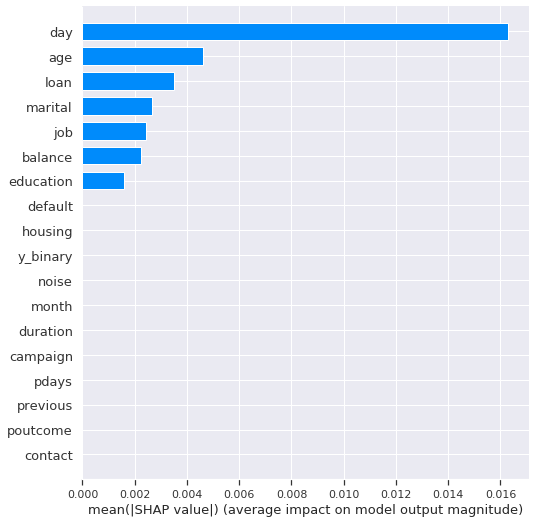

[array([-0.00462702, -0.00242564, -0.00266012,  0.00160887,  0.        ,
        0.00225921,  0.        , -0.00352016,  0.        , -0.01627176,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ])]


In [29]:
shap_predictor = shap_predictor_factory(feature_names, example_model)
example_explainer = get_explainer(shap_predictor, dataframe)
example_shap_values = generate_explanation(example_explainer, dataframe, index_to_explain, example_model, chart=True, feature_names=feature_names)
print(example_shap_values)

In [30]:
instance_for_metrics = convert_dataframe_numpy(dataframe, index_to_explain)[0]

In [31]:
# Our external sensitivity metric shouldn't have to know about implementation of the explanation
def simple_explainer_factory(explainer, num_perturbations=NUM_PERTURBATIONS):
    def explainer_simple(this_instance):
        return explainer.shap_values(this_instance, nsamples=num_perturbations)[0]
    return explainer_simple

# Our fidelity function expects a model with a predict() attribute that just takes an array of numbers
def fidelity_model_factory(model, feature_names):
    class fidelity_model():
        def predict(instance):
            return predict_wrapper(model, [instance], feature_names)
    return fidelity_model

In [32]:

example_explainer_simple = simple_explainer_factory(example_explainer)

# sensitivity = calculate_sensitivity(example_explainer_simple, example_shap_values, instance_for_metrics, metadata)
# sensitivity

In [33]:
test_arr = [10, 5, -7]
result = [abs(ele) for ele in test_arr]
srt = sorted(result)
srt

[5, 7, 10]

In [34]:

    
fidelity_model = fidelity_model_factory(example_model, feature_names)
infidelity = calculate_infidelity(example_shap_values[0], fidelity_model, instance_for_metrics, metadata)
infidelity

array([[0.5409354]], dtype=float32)

## Validating the metrics

1) Run multiple times, with fresh model runs. Do we get consistent results?
2) Consider the end points. Do these tend to a sensible value i.e. one or zero? 
3) Build simple linear models (as desribed below).
4) Test with Iris dataset to see if values are sensible. 
5) Sense check with bank marketing dataset - duration included vs not included

Meaningful endpoints - tend to zero or one? 
Think about comparisons between datasets. If scaling arbitrarily, means is dependent on dataset. 
Could use Iris dataset? As known relationships between features/output. 

#### Fidelity

* Set up a simple dataset with x1, x2 and y. 
* Output of y = x1 (or is clearly related in some way). x2 bears no relation to the output of y: it is just noise. 
* Manually set up two 'explanations' e1 and e2 with the most salient features being x1 and x2 respectively (we can use the actual explanation for e1, and use this to baseline e2). 
* We would expect e1 to have higher fidelity / lower infidelity. This is because: adjusting the output with higher explanation value will have bigger impact for e1, and lower (theoretically none for e2).
* Can try different variants of this (e.g. where x2 is loosely related to y) to see if that nudges the fidelity metric the right way. 
* _Sensitivity doesn't really work for this - due to the fake explanation (the explanation would change completely for e2)._

#### Sensitivity

* Build a model representing a piecewise function with discontinuities. Sensitivity should be higher for instances around the discountinuities. 

### 1) Multiple runs

Conclusion: sensitivities appear to vary somewhat arbitrarily. This may be due to different model configurations. 

Fidelities for explanations with similar salient features are similar. This is encouraging. 

It will be interesting to run this for a larger sample and compare fidelities and sensitivities. 

Iris dataset will be useful for further validating - this is a weakly correlated, unbalanced dataset, and so model outputs can look quite different between fittings. 

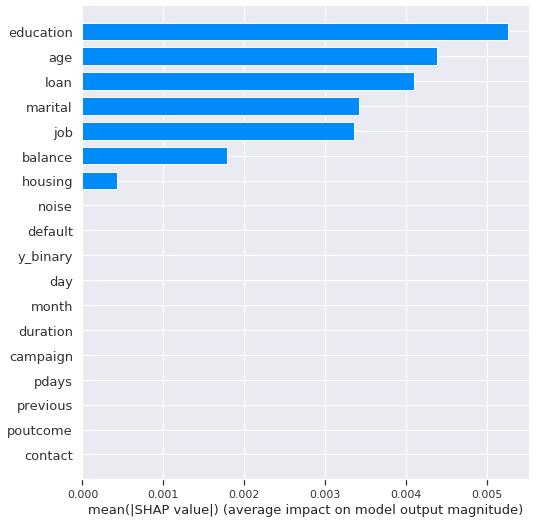

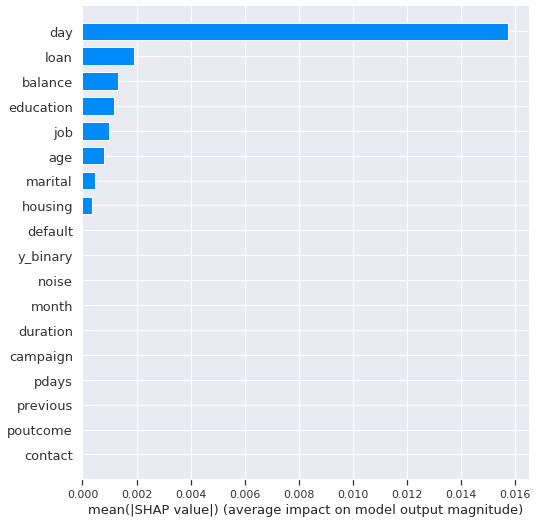

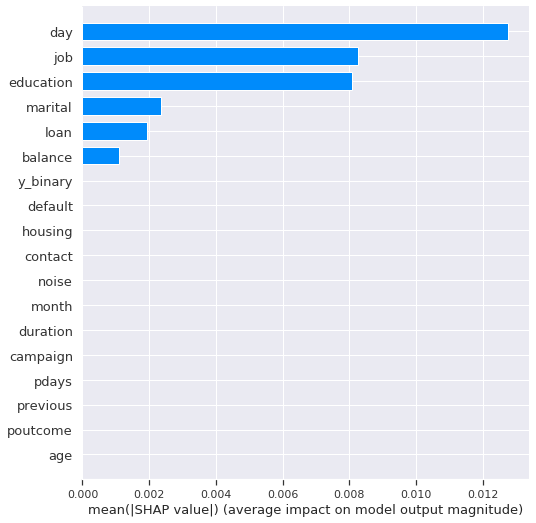

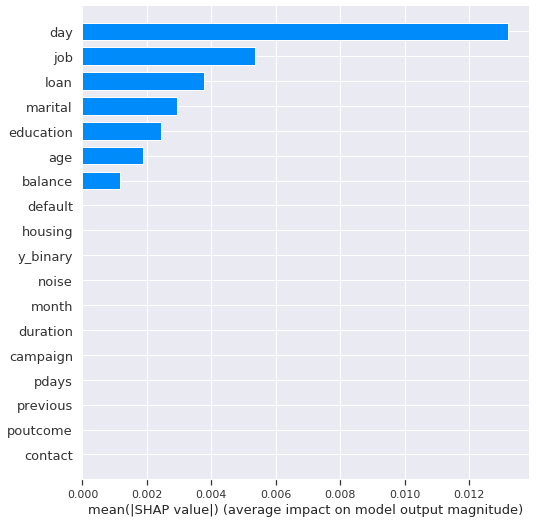

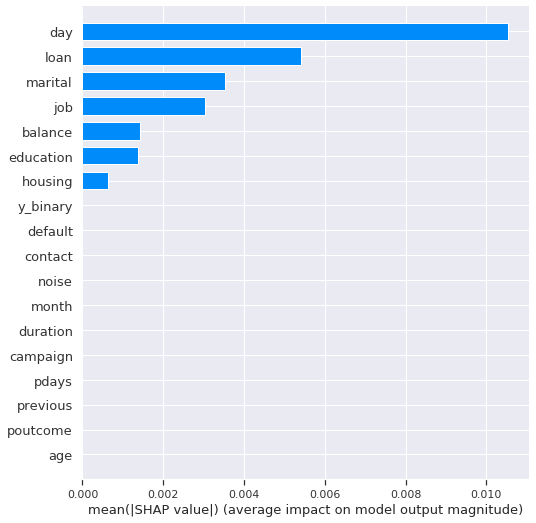

In [36]:
models = []
outputs = []
shap_values = []
sensitivities = []
infidelities = []
for index in range (5):
    
    # Build model
    metrics_test_model, _ = create_fit_model(train_ds, input_layer, METRICS, epochs=10, verbose=0)
    models.append(metrics_test_model)
    
    # Get model output
    metrics_test_instance = convert_dataframe_numpy(dataframe, index_to_explain)
    metrics_test_output = predict_wrapper(metrics_test_model, metrics_test_instance, feature_names)
    outputs.append(metrics_test_output)
    
    # Generate explanation
    metrics_test_predictor = shap_predictor_factory(feature_names, metrics_test_model)
    metrics_test_explainer = get_explainer(metrics_test_predictor, dataframe)
    metrics_test_shap_values = generate_explanation(metrics_test_explainer, dataframe, index_to_explain, metrics_test_model, chart=True, feature_names=feature_names)
    shap_values.append(metrics_test_shap_values)
    
    # Generate metrics
#     metrics_test_explainer_simple = simple_explainer_factory(metrics_test_explainer)
#     metrics_test_sensitivity = calculate_sensitivity(metrics_test_explainer_simple, metrics_test_shap_values, metrics_test_instance[0], metadata)
#     sensitivities.append(metrics_test_sensitivity)
    metrics_test_infidelity_model = fidelity_model_factory(metrics_test_model, feature_names)
    metrics_test_infidelity = calculate_infidelity(metrics_test_shap_values[0], metrics_test_infidelity_model, metrics_test_instance[0], metadata)
    infidelities.append(metrics_test_infidelity)

In [38]:
models, shap_values, sensitivities, infidelities

([<tensorflow.python.keras.engine.sequential.Sequential at 0x7f393807e100>,
 [[array([ 0.00438491, -0.003349  , -0.00341862,  0.0052518 ,  0.        ,
           0.00178832,  0.00043148,  0.00409329,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ])],
  [array([-0.00080871, -0.00098783, -0.00048191,  0.00115231,  0.        ,
           0.00129694, -0.0003479 , -0.00189836,  0.        , -0.01572509,
           0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ])],
  [array([ 0.        , -0.00826843,  0.00236512,  0.00808456,  0.        ,
           0.00109778,  0.        , -0.00193887,  0.        , -0.01274634,
           0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ])],
  [array([-0.001867  , -0.00535911, -0.00294232,  0.00244377,  0.        ,
           0.00115

#### 2) Consider end points

Sensitivity: this is just the L2 difference between two vectors (representing the two explanations). So the minimum is zero, with no theoretical maximum.

Fidelity: there is no maximum or minimum value. Can be negative or positive. It is not clear what zero actually represents. Maybe some room for improvement here? Note that Yeh. et al never get a negative value - have I implemented/understood maths correctly? 


#### 3) Linear models

### Overfitted model

Approach - try building models with 5 - 50 epochs (multiples of 5), with and without dropout. Compare metrics on TEST as well as training set. 

Hypothesis - models with higher epochs, and without dropout, will have higher accuracy on the training set but lower on test set. 

In [62]:
overfitting_results = pd.DataFrame(columns=['dropout', 'epochs', 'train_loss', 'train_accuracy', 'train_auc', 'test_loss', 'test_accuracy', 'test_auc'])


In [63]:
# With dropout
tf.get_logger().setLevel('ERROR')
for epochs in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 40, 50]:
    print(f'Calculating epoch: {epochs}')
    
    # With dropout
    model_with_dropout, history_with_dropout = create_fit_model(train_ds, input_layer, METRICS, epochs=epochs, dropout=True, verbose=0)
    test_loss, test_accuracy, test_precision, test_recall, test_auc = model_with_dropout.evaluate(test_ds)
    overfitting_results = overfitting_results.append({
        'dropout': True,
        'epochs': epochs,
        'train_loss': history_with_dropout.history['loss'][-1],
        'train_accuracy': history_with_dropout.history['accuracy'][-1],
        'train_auc': history_with_dropout.history['auc'][-1],
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'test_auc': test_auc
    }, ignore_index=True)
    
    # Without dropout
    model_without_dropout, history_without_dropout = create_fit_model(train_ds, input_layer, METRICS, epochs=epochs, dropout=False, verbose=0)
    test_loss, test_accuracy, test_precision, test_recall, test_auc = model_without_dropout.evaluate(test_ds)
    overfitting_results = overfitting_results.append({
        'dropout': False,
        'epochs': epochs,
        'train_loss': history_without_dropout.history['loss'][-1],
        'train_accuracy': history_without_dropout.history['accuracy'][-1],
        'train_auc': history_without_dropout.history['auc'][-1],
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'test_auc': test_auc
    }, ignore_index=True)


Calculating epoch: 1
91/91 [==============================] - 1s 5ms/step - loss: 0.2938 - accuracy: 0.8917 - precision: 0.6246 - recall: 0.2088 - auc: 0.7906
Calculating epoch: 2
91/91 [==============================] - 1s 5ms/step - loss: 0.2927 - accuracy: 0.8882 - precision: 0.5462 - recall: 0.3155 - auc: 0.7911
Calculating epoch: 3
91/91 [==============================] - 1s 5ms/step - loss: 0.2912 - accuracy: 0.8907 - precision: 0.5717 - recall: 0.2987 - auc: 0.7940
Calculating epoch: 4
91/91 [==============================] - 2s 7ms/step - loss: 0.2937 - accuracy: 0.8914 - precision: 0.5915 - recall: 0.2603 - auc: 0.7902
Calculating epoch: 5
91/91 [==============================] - 1s 5ms/step - loss: 0.2906 - accuracy: 0.8907 - precision: 0.5862 - recall: 0.2547 - auc: 0.7944
Calculating epoch: 6
91/91 [==============================] - 1s 5ms/step - loss: 0.2991 - accuracy: 0.8876 - precision: 0.5439 - recall: 0.3015 - auc: 0.7896
Calculating epoch: 7
91/91 [==================

In [64]:
overfitting_results

,dropout,epochs,train_loss,train_accuracy,train_auc,test_loss,test_accuracy,test_auc
0,True,1,0.321270,0.830448,0.719060,0.297430,0.893398,0.785512
1,False,1,0.313512,0.887815,0.755049,0.293771,0.891739,0.790568
2,True,2,0.298255,0.892833,0.772010,0.294068,0.892956,0.790837
3,False,2,0.289854,0.893442,0.789919,0.292658,0.888201,0.791140
4,True,3,0.292650,0.893027,0.785712,0.292476,0.890965,0.789249
5,False,3,0.284758,0.895598,0.799935,0.291155,0.890744,0.794025
6,True,4,0.287514,0.895101,0.796318,0.292295,0.890965,0.793562
7,False,4,0.279499,0.897534,0.810426,0.293729,0.891408,0.790192
8,True,5,0.283317,0.895958,0.804912,0.295180,0.892292,0.785340
9,False,5,0.274944,0.898087,0.819175,0.290631,0.890744,0.794396


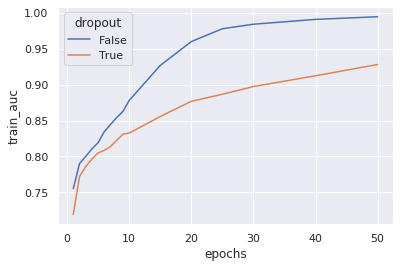

In [68]:
sns.lineplot(data=overfitting_results, x="epochs", y="train_auc", hue="dropout")

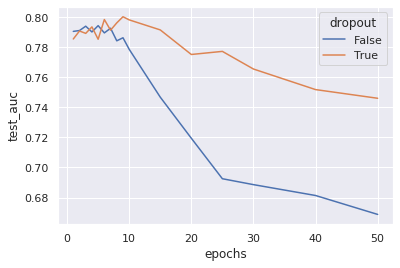

In [69]:
sns.lineplot(data=overfitting_results, x="epochs", y="test_auc", hue="dropout")

### Formal Verification

Sigmoid in output layer won't work without some sort of hack. 

If all we want is the class and not the probability, we can just use an argmax (>/< 0.5).

In [37]:
np.linalg.norm(np.array([[[1,2,3]]]) - np.array([[[4,5,6]]]))

5.196152422706632